# Lab session 13: K-means and K-modes
__Name: Makesh Srinivasan<br>
Registration number: 19BCE1717<br>
Course code: CSE4020<br>
Faculty: Dr. Abdul Quadir<br>
Slot: L31 + L32<br>
Date: 22-November-2021 Monday__<br><br>
    
Instructions:<br>
Perform Kmeans (manually and using package) and Kmodes on the dataset shown in class and a dataset of your choice.<hr>

### Structure: 

<strong>Part 1: Iris dataset</strong><br>
1) Dataset generation<br>
2) <a href="#kmeansscratch">K-Means from scratch</a><br>
3) <a href="#kmeans">K-Means using Sklearn</a><br>
4) <a href="#kmodes">K-Modes</a><br><br>

<strong>Part 2: The dataset from class</strong><br>
1) Dataset generation<br>
2) <a href="#kmeansscratch2">K-Means from scratch</a><br>
3) <a href="#kmeans2">K-Means using Sklearn</a><br>
4) <a href="#kmodes2">K-Modes</a><br><br>

<h2><center>Part 1: Iris</center></h2>

### Dataset generation:

Load the Iris dataset using the URL 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'.
The Iris dataset consists of 3 species each with fifty instances. I chose Iris because the clustering of Iris species is fairly distinct which becomes useful while visualising the plots

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objs as go
import plotly
import plotly.io as pio
import plotly.offline as pyo
pio.renderers.default='notebook'
pyo.init_notebook_mode(connected=True)

__Load data:__

In [24]:
def load(URL_):
    data = pd.read_csv(URL_, header = None)
    print("Data loaded...")
    data = data.drop(3, axis=1) # drop the 4th column so that we can visualise in 3D
    data = data.rename({0: 'SepalLengthCm', 1: 'SepalWidthCm', 2: 'PetalLengthCm', 4: 'Species'}, axis=1)
    data=data.replace(to_replace="Iris-setosa",value=0)
    data=data.replace(to_replace="Iris-versicolor",value=1)
    data=data.replace(to_replace="Iris-virginica",value=2)
    return data
data = load('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')
data

Data loaded...


SepalLengthCm  SepalWidthCm  PetalLengthCm  Species
0              5.1           3.5            1.4        0
1              4.9           3.0            1.4        0
2              4.7           3.2            1.3        0
3              4.6           3.1            1.5        0
4              5.0           3.6            1.4        0
..             ...           ...            ...      ...
145            6.7           3.0            5.2        2
146            6.3           2.5            5.0        2
147            6.5           3.0            5.2        2
148            6.2           3.4            5.4        2
149            5.9           3.0            5.1        2

[150 rows x 4 columns]

__Drop the label attribute (Species):__

In [25]:
X = data.drop("Species", axis=1) # drop the label - Species
y = data[["Species"]]
X.head(5)

SepalLengthCm  SepalWidthCm  PetalLengthCm
0            5.1           3.5            1.4
1            4.9           3.0            1.4
2            4.7           3.2            1.3
3            4.6           3.1            1.5
4            5.0           3.6            1.4

__Visualise the dataset:__

In [27]:
def plot_data(colour, data):
    c = list(data.columns)
    trace1 = go.Scatter3d(x=data[c[0]], y=data[c[1]], z=data[c[2]], mode='markers',marker = dict(color = colour),name = "Dataset")
    fig1 = go.Figure(data=[trace1])
    fig1.update_layout(scene = dict(xaxis_title=str(c[0]),yaxis_title=str(c[1]),zaxis_title=str(c[2])))
    plotly.offline.iplot(fig1, filename=str(colour))  
plot_data("grey", data)

NOTE: We can see that there are approximately 2 or 3 clusters from the image.

<hr>

<div id="kmeansscratch"><center><h3>1) KMeans from scratch</h3></center></div>

In [5]:
class K_means:
    def __init__(self, k, data, cluster_attempt):
        self.column_names = list(data.columns.values)
        self.k = k
        self.data = self.transform_to_matrix(data)
        self.cluster_attempt = cluster_attempt
        self.clustered_data = []
        self.centroids = []
        self.variance = 0
        self.variance_cluster_attemptwise = []
        self.kmeans()
    
    def kmeans(self):
        cluster_attempt = 1
        cluster_centroids = []
        cluster_clustered_data = []
        cluster_variance = []
        for i in range(self.cluster_attempt):
            print(f"Clustering attempt {cluster_attempt}: \n\n")
            iteration = 1
            self.centroids = self.initialise_centroids()
            print(f"Initialised centroids: {self.centroids.tolist()}\n")
            while True:
                print(f"Iteration {iteration}:")
                if iteration != 1:
                    print(f"Centroids = {self.centroids}\n")
                
                new_cluster = self.cluster()
                if self.clustered_data != new_cluster:
                    self.clustered_data = new_cluster
                    self.visualise_cluster(len(self.data[0]))
                    self.centroids = self.update_centroids()
                else:
                    cluster_centroids.append(self.centroids)
                    cluster_clustered_data.append(self.clustered_data)
                    self.visualise_cluster(len(self.data[0]))
                    print("No change in clustering as previous iteration. Terminating KMeans...")
                    break
                iteration += 1
            variance = self.get_variance()
            print(f"Variance = {variance}")
            cluster_variance.append(variance)
            print("__"*70)
            cluster_attempt += 1
        best_cluster_index = cluster_variance.index(min(cluster_variance))
        print(f"The best clustering attempt is Attempt = {best_cluster_index+1} with variance = {min(cluster_variance)}")
        self.centroids = cluster_centroids[best_cluster_index]
        self.clustered_data = cluster_clustered_data[best_cluster_index]
        self.variance = min(cluster_variance)
        self.variance_cluster_attemptwise = cluster_variance
        if self.cluster_attempt != 1:
            self.plot_variance()
        print("__"*70)
        
    def transform_to_matrix(self, df):
        df = df.values.tolist()
        df = np.array(df)
        return df

    def plot_variance(self):
        x = np.arange(1,self.cluster_attempt+1)
        fig = plt.figure()
        ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
        y = self.variance_cluster_attemptwise
        ax.plot(x, y)
        ax.set_xlabel("Cluster attempts")
        ax.set_title('Variance over cluster attempts')
        ax.set_xticks(x)
        plt.show()
        
    def get_variance(self):
        total_variance = 0
        category = 0
        catwise = []
        new_centroids = []
        while category < self.k:
            buffer = []
            for i in range(len(self.clustered_data)):
                if category == self.clustered_data[i][1]:
                    buffer.append(self.clustered_data[i])
            catwise.append(buffer)
            category += 1
        category = 0
        while category < self.k:
            variance = 0
            buffer = catwise[category]
            distances = []
            for i in range(len(buffer)):
                variance += self.euclidean_distance(self.centroids[buffer[i][1]], buffer[i][0])**2
            variance = variance/len(buffer)
            total_variance += variance
            category += 1
        return total_variance
        
    def initialise_centroids(self):
        while True:
            centroids = self.data[np.random.choice(self.data.shape[0], self.k, replace=False), :]
            flag = 0
            for i in range(len(centroids)):
                for j in range(len(centroids)):
                    if i != j:
                        if str(centroids[i]) == str(centroids[j]):
                            flag = 1
            if flag == 0:
                return centroids
    
    def euclidean_distance(self, c1, c2):
        distance = 0
        for i in range(len(c1)):
            distance += (c1[i]-c2[i])**2
        return np.sqrt(distance)
    
    def cluster(self):
        clustered_data_local = []
        for i in range(len(self.data)):
            distances = [self.euclidean_distance(centroid, self.data[i]) for centroid in self.centroids]
            minimum = distances[0]
            cluster_name = 0
            for j in range(len(distances)):
                if minimum > distances[j]:
                    minimum = distances[j]
                    cluster_name = j
            clustered_data_local.append([list(self.data[i]), cluster_name])
        return clustered_data_local
    
    def update_centroids(self):
        category = 0
        catwise = []
        new_centroids = []
        while category < self.k:
            buffer = []
            for i in range(len(self.clustered_data)):
                if category == self.clustered_data[i][1]:
                    buffer.append(self.clustered_data[i])
            catwise.append(buffer)
            category += 1
        category = 0
        while category < self.k:
            mean_coordinates = [0]*len(self.data[0])
            buffer = catwise[category]
            for i in range(len(self.data[0])):
                for j in range(len(buffer)):
                    mean_coordinates[i] += buffer[j][0][i]
            for i in range(len(self.data[0])):
                mean_coordinates[i] = mean_coordinates[i]/len(buffer)
            new_centroids.append(mean_coordinates)
            category += 1
        return new_centroids
    
    def visualise_cluster(self, dim):
        local_df = []
        for i in range(len(self.clustered_data)):
            buffer = []
            buffer.extend(self.clustered_data[i][0])
            buffer.append(self.clustered_data[i][1])
            local_df.append(buffer)
        local_df = np.array(local_df)
        dataset = pd.DataFrame(local_df)
        if dim == 2:
            c = []
            symbols = ["o", "x", "+", "d"]
            for i in range(self.k):
                c.append(dataset[dataset.iloc[:,-1] == i])
                name = "cluster " + str(i)
                plt.scatter(np.array(c[i].iloc[:,0]), np.array(c[i].iloc[:,1]), marker=symbols[i], label=name, s=100)
            x,y=[],[]
            for i in range(len(self.centroids)):
                x.append(self.centroids[i][0])
                y.append(self.centroids[i][1])
            plt.scatter(np.array(x), np.array(y), marker='*', label='Centroids', c="red", s=100)
            plt.xlabel('feature 1')
            plt.ylabel('feature 2')
            plt.legend()
            plt.show()
        elif dim == 3:
            trace1 = go.Scatter3d(x=dataset.iloc[:,0].tolist(), y=dataset.iloc[:,1].tolist(), z=dataset.iloc[:,2].tolist(), mode='markers',marker = dict(color = dataset.iloc[:,3]), name = "Dataset")
            x,y,z = [], [], []
            for i in range(len(self.centroids)):
                x.append(self.centroids[i][0])
                y.append(self.centroids[i][1])
                z.append(self.centroids[i][2])
            trace0 = go.Scatter3d(x=x,y=y,z=z,mode='markers',marker = dict(color = "red"),name='Centroids',marker_symbol="x", marker_size=3)
            fig = go.Figure(data=[trace1, trace0])
            cols = self.column_names
            fig.update_layout(scene = dict(xaxis_title=cols[0],yaxis_title=cols[1],zaxis_title=cols[2]))
            name_f = str(self.centroids) + "simple-3d-scatter"
            plotly.offline.iplot(fig, filename=name_f)

__Explanation:__

The object (instance of the class <strong>K_means</strong> - from scratch) kmeans_manual is built by passing three arguments and they are: <br>
1) k = number of clusters to build<br>
2) data = dataset without the label attribute<br>
3) cluster_attempt = number of cluster attempts (explained below)<br>
<br>
    The <strong>cluster_attempt</strong> parameter referes to the number of independent kmeans clusters to build. The process of clustering stops when there is no change in the clusters for two consecutive iterations. And generally, this means the variance for the last iteration will be the lowest. But, we would not know if this clustering is the "best" overall way to cluster the dataset. Thus, we generate multiple kmeans clustering independent of each other (cluster_attempt - number of cluster attempts) and choose the model with the lowest variance.

__Generating the KMeans model:__

Given/Assumptions:<br>
We know that there are 3 Iris species; hence, we will set the clusters <strong>k = 3</strong><br>
The cluster attempt is set as 2 but this is arbitrary. It has to be high enough to generate maximum number of unique clustering models, but also low enough to not generate repetitive clustering models. Here in this lab exercise, I chose 2 because only 16 scatter3d plots are rendering on the HTML document, and cluster_attempt = 2 reduces the number of plots to be rendered. (Set it to 3 if more cluster models are to be genereated) 

In [29]:
kmeans_manual = K_means(3, X, cluster_attempt = 2)

Clustering attempt 1: 


Initialised centroids: [[6.2, 2.2, 4.5], [5.6, 2.7, 4.2], [6.7, 2.5, 5.8]]

Iteration 1:


Iteration 2:
Centroids = [[6.283333333333335, 2.7208333333333337, 4.7375], [5.288636363636364, 3.136363636363637, 2.6352272727272723], [6.8500000000000005, 3.073684210526315, 5.742105263157893]]



Iteration 3:
Centroids = [[6.049999999999999, 2.8033333333333337, 4.595], [5.039655172413793, 3.2879310344827593, 1.7413793103448276], [6.9125000000000005, 3.099999999999999, 5.846874999999999]]



Iteration 4:
Centroids = [[5.94375, 2.7624999999999997, 4.450000000000001], [5.007843137254902, 3.400000000000001, 1.4941176470588236], [6.877142857142857, 3.0828571428571423, 5.794285714285712]]



Iteration 5:
Centroids = [[5.88360655737705, 2.740983606557377, 4.388524590163935], [5.005999999999999, 3.4180000000000006, 1.464], [6.853846153846153, 3.0769230769230766, 5.715384615384615]]



Iteration 6:
Centroids = [[5.868333333333334, 2.74, 4.381666666666667], [5.005999999999999, 3.4180000000000006, 1.464], [6.852499999999999, 3.0699999999999994, 5.692499999999999]]



No change in clustering as previous iteration. Terminating KMeans...
Variance = 1.398892611111111
____________________________________________________________________________________________________________________________________________
Clustering attempt 2: 


Initialised centroids: [[5.5, 2.6, 4.4], [6.1, 2.6, 5.6], [4.5, 2.3, 1.3]]

Iteration 1:


Iteration 2:
Centroids = [[5.808333333333333, 2.7437500000000004, 4.227083333333334], [6.680769230769228, 2.990384615384615, 5.532692307692305], [5.005999999999999, 3.4180000000000006, 1.464]]



Iteration 3:
Centroids = [[5.825925925925925, 2.733333333333334, 4.314814814814816], [6.77391304347826, 3.034782608695652, 5.6], [5.005999999999999, 3.4180000000000006, 1.464]]



Iteration 4:
Centroids = [[5.846551724137931, 2.7327586206896552, 4.363793103448276], [6.8357142857142845, 3.064285714285713, 5.654761904761903], [5.005999999999999, 3.4180000000000006, 1.464]]



No change in clustering as previous iteration. Terminating KMeans...
Variance = 1.400585840913932
____________________________________________________________________________________________________________________________________________
The best clustering attempt is Attempt = 1 with variance = 1.398892611111111


____________________________________________________________________________________________________________________________________________


<strong>Inference: </strong><br>
The "variance over cluster attempts" plot shows the value of the variance over each cluster attempts. As mentioned earlier, the lower the variance, better the clustering is. Hence, we select the clustering attempt with the lowest variance which in this case is <strong>attempt 1</strong> with the value of 1.39. The image corresponding to that cluster attempt also shows three distinct clusters for three species of Iris flowers. Hence, this clustering can be accepted as the best overall cluster.

<hr>

<div id="kmeans"><center><h3>2) KMeans using Sklearn</h3></center></div>

In [7]:
from sklearn.cluster import KMeans

__Generate KMeans cluster:__

Create the KMeans object and fit the data to generate a KMeans model with <strong>3 clusters</strong>

In [8]:
X = np.array(X)
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
prediction = kmeans.predict(X)

__Visualise the clusters:__

In [9]:
plot_data(prediction, data)

<strong>Inference: </strong><br>
The clustering done using the Sklearn package and the manually built code is the same.

<hr>

<div id="kmodes"><center><h3>3) KModes using Sklearn</h3></center></div>

In [10]:
from kmodes.kmodes import KModes

__Generate KModes cluster:__

In [11]:
kmode = KModes(n_clusters=3)
kmode_prediction = kmode.fit_predict(data)

__Visualise the clusters:__

In [12]:
plot_data(kmode_prediction, data)

<strong>Inference: </strong><br>
The clustering done using the kmodes package is different from the KMeans (both manual and package). It is also apparent that KModes is not a good clustering algorithm to adopt here because the cluster_1 (blue) is also fading into the other two clusters. KModes is preferable for categorical data and since Iris dataset is numerical, it makes more sense to use KMeans for clustering than KModes.

<hr>

<h2><center>Part 2: dataset from class</center></h2>

### Dataset generation:

In [13]:
x = np.array([2,2,5,4,8,6,5,5,6,4])
y = np.array([4,6,6,7,3,6,2,7,3,4])
df = pd.DataFrame(data=x,columns=['x'])
df['y'] = y.tolist()
df

x  y
0  2  4
1  2  6
2  5  6
3  4  7
4  8  3
5  6  6
6  5  2
7  5  7
8  6  3
9  4  4

__Visualise the dataset:__

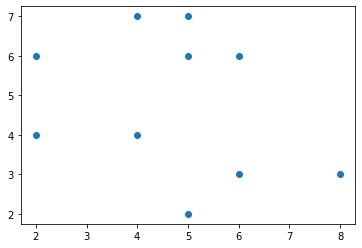

In [14]:
plt.scatter(df.x,df.y)
plt.show()

<div id="kmeansscratch2"><center><h3>1) KMeans from scratch</h3></center></div>

__K = 2:__

Clustering attempt 1: 


Initialised centroids: [[2, 4], [6, 6]]

Iteration 1:


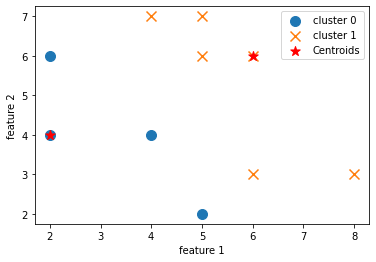

Iteration 2:
Centroids = [[3.25, 4.0], [5.666666666666667, 5.333333333333333]]



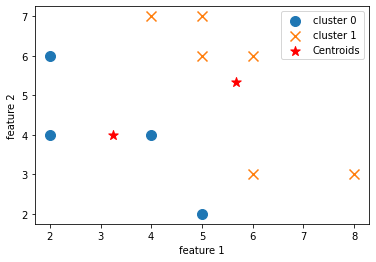

No change in clustering as previous iteration. Terminating KMeans...
Variance = 8.131944444444445
____________________________________________________________________________________________________________________________________________
The best clustering attempt is Attempt = 1 with variance = 8.131944444444445
____________________________________________________________________________________________________________________________________________


In [15]:
kmeans_manual_2 = K_means(2, df, cluster_attempt = 1)

The clustering of K = 2 is shown above but only one cluster attempt is done to reduce the number of plots being displayed on the report

__K = 3:__

Clustering attempt 1: 


Initialised centroids: [[5, 2], [8, 3], [2, 6]]

Iteration 1:


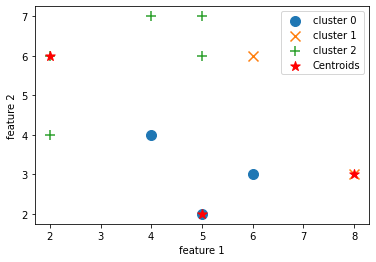

Iteration 2:
Centroids = [[5.0, 3.0], [7.0, 4.5], [3.6, 6.0]]



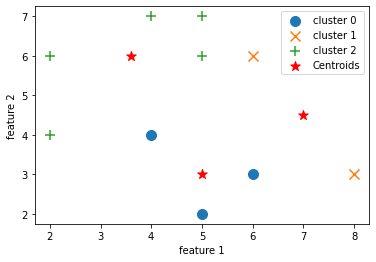

No change in clustering as previous iteration. Terminating KMeans...
Variance = 7.623333333333333
____________________________________________________________________________________________________________________________________________
The best clustering attempt is Attempt = 1 with variance = 7.623333333333333
____________________________________________________________________________________________________________________________________________


In [16]:
kmeans_manual_3 = K_means(3, df, cluster_attempt = 1)

The clustering of K = 3 is shown above but only one cluster attempt is done to reduce the number of plots being displayed on the report

__K = 4:__

Clustering attempt 1: 


Initialised centroids: [[5, 7], [5, 2], [5, 6], [2, 4]]

Iteration 1:


Iteration 2:
Centroids = [[4.5, 7.0], [6.333333333333333, 2.6666666666666665], [5.5, 6.0], [2.6666666666666665, 4.666666666666667]]



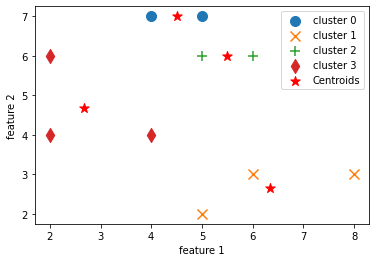

No change in clustering as previous iteration. Terminating KMeans...
Variance = 4.055555555555555
____________________________________________________________________________________________________________________________________________
The best clustering attempt is Attempt = 1 with variance = 4.055555555555555
____________________________________________________________________________________________________________________________________________


In [17]:
kmeans_manual_4 = K_means(4, df, cluster_attempt = 1)

The clustering of K = 4 is shown above but only one cluster attempt is done to reduce the number of plots being displayed on the report

<hr>

<div id="kmeans2"><center><h3>2) KMeans using Sklearn</h3></center></div>

In [18]:
def plot_data_2d(colour):
    fig = px.scatter(df, x="x", y="y", color=colour, symbol=colour)
    fig.update_traces(marker_size=10)
    fig.show()

The clustering of K = 3 is shown below:

In [19]:
df_X = np.array(df)
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_X)
kmeans_prediction = kmeans.predict(df_X)
kmeans_prediction

array([2, 2, 0, 0, 1, 0, 1, 0, 1, 2], dtype=int32)

In [20]:
plot_data_2d(kmeans_prediction)

<div id="kmodes2"><center><h3>3) KModes using Sklearn</h3></center></div>

Generate the dataset shown in class:

In [21]:
hair_colour = np.array(["blonde", "brunette", "red", "black", "brunette", "black", "red", "black"])
eye_colour = np.array(["amber", "grey", "green", "hazel", "amber", "grey", "green", "hazel"])
skin_colour = np.array(["fair", "brown", "brown", "brown", "fair", "brown", "fair", "fair"])
df = pd.DataFrame(data=hair_colour,columns=['hair_colour'])
df['eye_colour'] = eye_colour.tolist()
df['skin_colour'] = skin_colour.tolist()
df

hair_colour eye_colour skin_colour
0      blonde      amber        fair
1    brunette       grey       brown
2         red      green       brown
3       black      hazel       brown
4    brunette      amber        fair
5       black       grey       brown
6         red      green        fair
7       black      hazel        fair

The clustering of K = 2 using K-Modes is shown below:

In [22]:
kmode = KModes(n_clusters=2)
kmode_prediction = kmode.fit_predict(df)
kmode_prediction

array([1, 0, 0, 0, 1, 0, 1, 0], dtype=uint16)

In [23]:
plot_data(kmode_prediction, df)

<hr>

<h3>Conclusion:<h3>

The dataset from class and the Iris dataset are clustered using Kmeans (manual and sklearn package) and Kmodes are performed